In [75]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical

In [76]:
def load_doc(filename):
	file = open(filename, 'r', encoding = 'utf-8')
	text = file.read()
	file.close()
	return text

filename = "/kaggle/input/flickr30k/captions.txt"

doc = load_doc(filename)
print(doc[:450])

image_name,comment_number,comment
1000092795.jpg,0,Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg,1,Two young  White males are outside near many bushes .
1000092795.jpg,2,Two men in green shirts are standing in a yard .
1000092795.jpg,3,A man in a blue shirt standing in a garden .
1000092795.jpg,4,Two friends enjoy time spent together .
10002456.jpg,0,Several men in hard hats are operating a gia


In [77]:
def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split(",")
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[2:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 31784 


In [78]:
descriptions['1029450589']

['An adult wearing a gray shirt with red sleeves sleeping on a couch .',
 'A woman in black pants napping on the couch .',
 'A man sleeping in a green room on a couch .',
 'The young woman is sleeping in her room .',
 'A long-haired man sleeping on a couch']

In [79]:
def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)

clean_descriptions(descriptions)

In [80]:
descriptions['1029450589']

['an adult wearing gray shirt with red sleeves sleeping on couch',
 'woman in black pants napping on the couch',
 'man sleeping in green room on couch',
 'the young woman is sleeping in her room',
 'longhaired man sleeping on couch']

In [81]:
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w', encoding='utf-8')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions_english.txt')

In [82]:
lines1 = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines1.append(key+".jpg")
data1 = '\n'.join(lines1[:len(lines1)*9//10])
data2 = '\n'.join(lines1[len(lines1)*9//10:])
file1 = open("image_train.txt", 'w', encoding='utf-8')
file2 = open("image_test.txt", 'w', encoding='utf-8')
file1.write(data1)
file2.write(data2)
file1.close()
file2.close()

In [83]:
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

filename = 'image_train.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 28606


In [84]:
images = '/kaggle/input/flickr30k/flickr30k_images/'
img = glob.glob(images + '*.jpg')
print(len(img))

31783


In [85]:
train_images_file = 'image_train.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

train_img = []

for i in img: 
    if i[len(images):] in train_images: 
        train_img.append(i) 

In [86]:

test_images_file = "image_test.txt"
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []

for i in img: 
    if i[len(images):] in test_images: 
        test_img.append(i) 

In [87]:
def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

train_descriptions = load_clean_descriptions('descriptions_english.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=28606


In [88]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [89]:
train_features = load(open("/kaggle/input/feature-vector/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=28605


In [90]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

143026

In [91]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 18628 -> 5064


In [92]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [46]:
vocab_size = len(ixtoword) + 1 
vocab_size

5065

In [93]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 74


In [94]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            if key+".jpg" not in photos:
                continue
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [95]:

glove_dir = ''
embeddings_index = {} 
f = open(os.path.join(glove_dir, '/kaggle/input/feature-vector/glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
"""
import fasttext
embeddings_index = fasttext.load_model('../input/fasttext-vietnamese-word-vectors-full/cc.vi.300.bin')
print('Found %s word vectors.' % len(embeddings_index.words))
"""

Found 400000 word vectors.


"\nimport fasttext\nembeddings_index = fasttext.load_model('../input/fasttext-vietnamese-word-vectors-full/cc.vi.300.bin')\nprint('Found %s word vectors.' % len(embeddings_index.words))\n"

In [96]:
embeddings_index['the']

array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
        3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
        1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
       -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
        4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
        7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
        1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
       -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
       -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
        6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
       -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
        8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
        1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
        1.4379e-01, -1.2325e-01, -5.8178e-02, -1.0290e-03, -8.21

In [97]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [98]:
embedding_matrix.shape

(5065, 200)

In [55]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [99]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 200)      1013000     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

In [100]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [101]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [119]:
model.optimizer.lr = 0.0001
epochs = 5
number_pics_per_bath = 6
steps = 1000

In [120]:
from itertools import islice
train_descriptions1 = dict(islice(train_descriptions.items(), 1000))
train_features1 = dict(islice(train_features.items(), 1000))


In [121]:
for i in range(epochs):
    generator1 = data_generator(train_descriptions1, train_features1, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator1, epochs=1, steps_per_epoch=steps, verbose=1)

1000/1000 [==============================] - 1013s 1s/step - loss: 3.5536


In [122]:
model.save_weights('/kaggle/working/weights.h5')

In [123]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model1 = Model(inputs=[inputs1, inputs2], outputs=outputs)

model1.layers[2].set_weights([embedding_matrix])
model1.layers[2].trainable = False

model1.compile(loss='categorical_crossentropy', optimizer='adam')

model1.load_weights('weights.h5')


In [124]:
images = '/kaggle/input/flickr30k/flickr30k_images/'

In [125]:
with open("/kaggle/input/feature-vector/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [126]:

def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model1.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

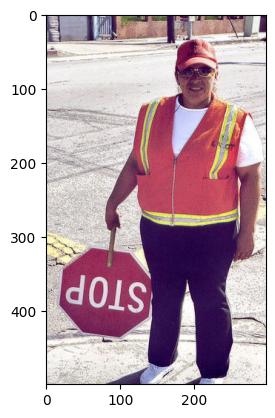

man in blue shirt is standing on the street


In [127]:
z=6
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))

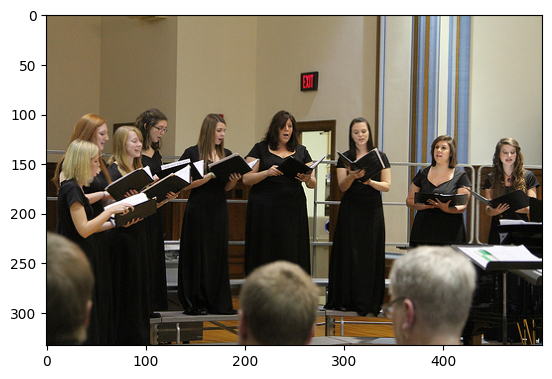

man in white shirt is standing on the of of the


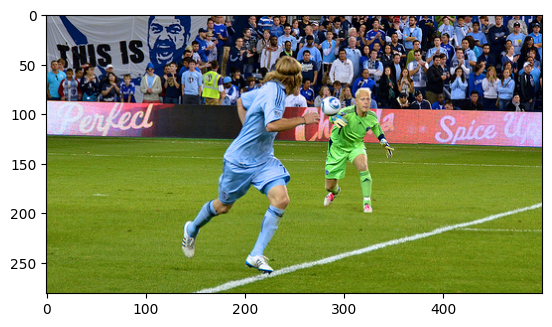

two men are playing in the air


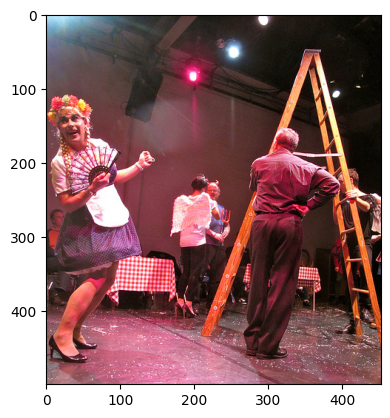

man in red shirt is standing on the air


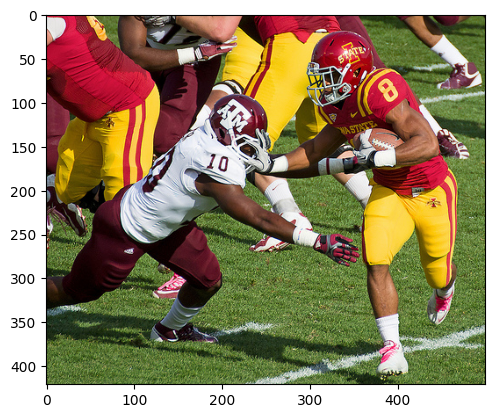

two people are sitting on the sponsored


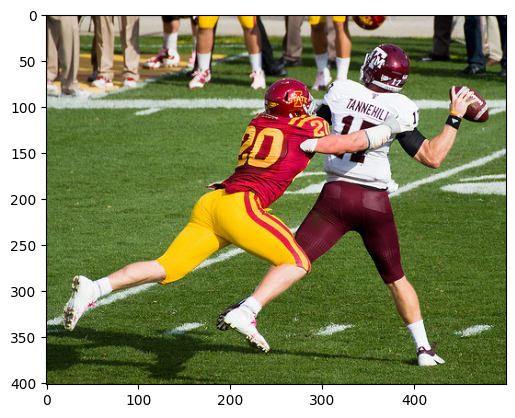

two boys are playing in the air


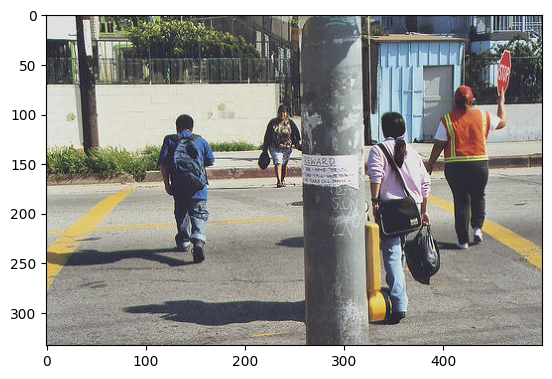

man in red shirt is standing on street


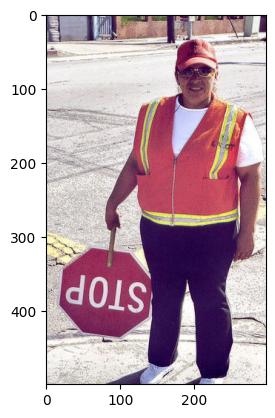

man in blue shirt is standing on the street


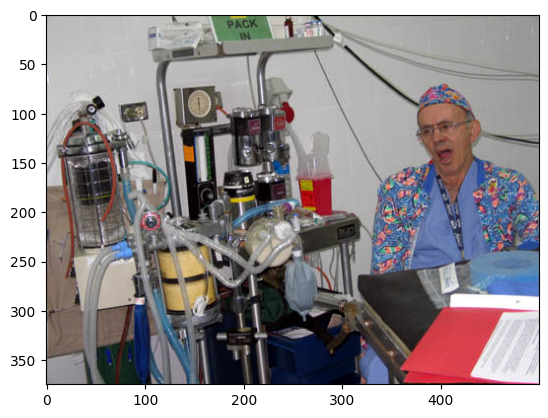

man in black shirt is standing on the wall


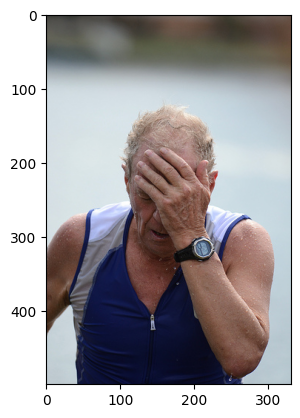

man in blue shirt is holding his face


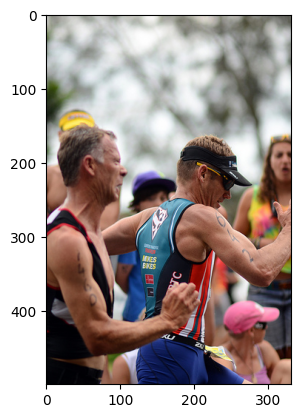

two people are ready to the air


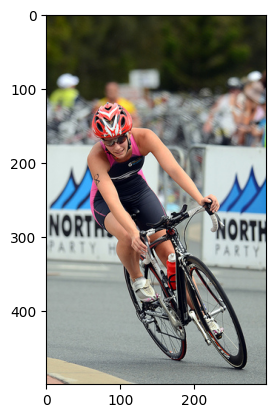

man in blue shirt and helmet is riding bike


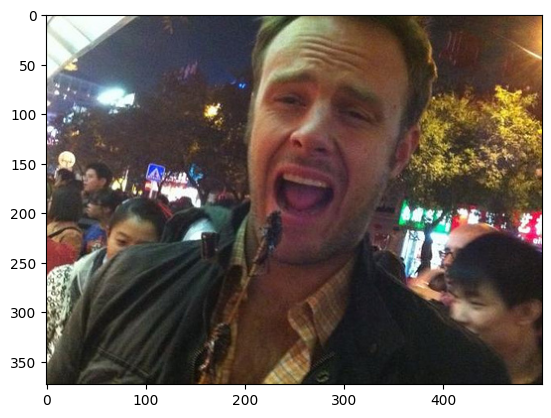

man in black shirt is standing at the camera


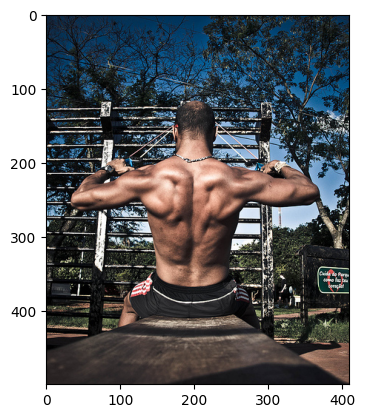

man in blue shirt is standing on the air


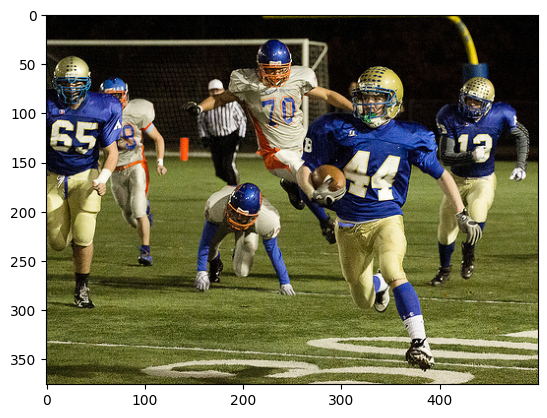

two people are sitting on the sponsored


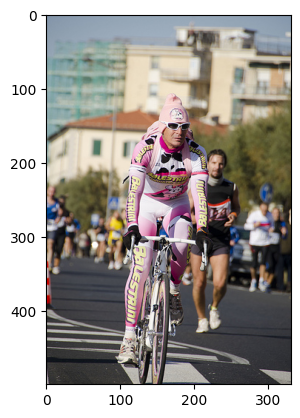

man wearing bike rides bike on the street


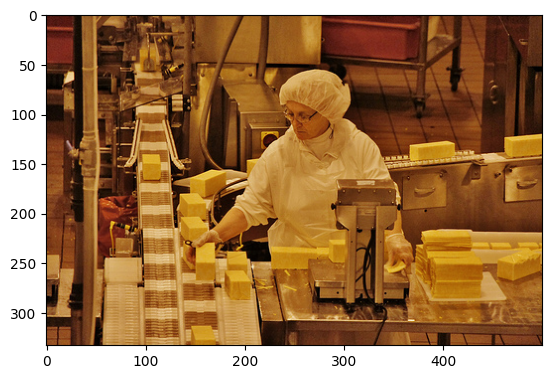

In [ ]:
 for z in range(200):   
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print(greedySearch(image))